In [4]:
!pip install pyhomogeneity
!pip install pymannkendall
!pip install statsmodels
!pip install scipy

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymannkendall as mk
import statsmodels.api as sm
from scipy.stats import gamma, theilslopes
from statsmodels.tsa.stattools import acf
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
PATH = "/content/drive/MyDrive/TP-Mate4/Datos/"
INDICES = ['PRCPTOT','SDII','CWD','CDD','R10mm','R20mm','R40mm','R95pTOT','R99pTOT','Rx1day','Rx5day']

In [8]:
df_indices_anual = pd.read_excel("/content/drive/MyDrive/TP-Mate4/Datos/indices_anuales.xlsx")
df_indices_estaciones = pd.read_excel("/content/drive/MyDrive/TP-Mate4/Datos/indices_estaciones.xlsx")
df_indices_anuales_por_periodo = pd.read_excel("/content/drive/MyDrive/TP-Mate4/Datos/indices_anuales_por_periodo.xlsx")
df_indices_estaciones_por_periodo = pd.read_excel("/content/drive/MyDrive/TP-Mate4/Datos/indices_estaciones_por_periodo.xlsx")

In [9]:
def df_to_series(df, index_col="fecha", values_col="pp"):
    """
    Convierte un dataframe en una serie de tiempo.

    Parámetros:
        df (pd.DataFrame): DataFrame
        index_col (str): Columna que se tomará como índice
        values_col (str): Columna que contiene los valores

    Retorna:
        pd.Series: Serie de tiempo
    """
    df = df.copy()
    serie = pd.Series(df[values_col].values, index=df[index_col])
    serie = serie.sort_index()

    return serie

def aplicar_mk_a_indices(df_indices, alpha=0.05, start_year=1961, end_year=2024):
    """
    Aplica el test de Mann-Kendall a todos los índices ETCCDI para un período dado.

    Funciona tanto para:
      - series anuales (una fila por año)
      - series anuales por estación (una fila por año por estación)

    Parámetros
    ----------
    df_indices : pd.DataFrame
        DataFrame con columnas de índices ETCCDI y al menos:
          - 'Año'
          - opcionalmente 'Estacion'
    alpha : float
        Nivel de significancia para el test de Mann-Kendall.
    start_year : int, optional
        Año de inicio del período a analizar (inclusive). Por defecto, None (todo el período).
    end_year : int, optional
        Año de fin del período a analizar (inclusive). Por defecto, None (todo el período).


    Retorna
    -------
    pd.DataFrame con las columnas:
        ['Indice', 'Estacion', 'Tendencia', 'Tau', 'p_value', 'S', 'Var(S)', 'slope', 'intercept']
    """

    df = df_indices.copy()
    if start_year is not None:
        df = df[df['Año'] >= start_year]
    if end_year is not None:
        df = df[df['Año'] <= end_year]


    columnas_indices = [c for c in df.columns
                        if c not in ['Año', 'Periodo', 'Estacion', 'Tipo']]

    resultados = []

    if 'Estacion' in df.columns and df['Estacion'].nunique() > 1:
        grupos = df.groupby('Estacion')
    else:
        grupos = [('Anual', df)]

    for nombre_grupo, df_grupo in grupos:
        df_grupo = df_grupo.sort_values('Año')

        for indice in columnas_indices:
            serie = df_grupo[indice].dropna().values
            if len(serie) > 0:
                mk_res = mk.original_test(serie, alpha=alpha)

                resultados.append({
                    'Indice': indice,
                    'Estacion': nombre_grupo,
                    'Tendencia': mk_res.trend,
                    'Tau': mk_res.Tau,
                    'p_value': mk_res.p,
                    'slope': mk_res.slope,
                    'intercept': mk_res.intercept
                })
            else:
                 resultados.append({
                    'Indice': indice,
                    'Estacion': nombre_grupo,
                    'Tendencia': 'No hay datos',
                    'Tau': None,
                    'p_value': None,
                    'slope': None,
                    'intercept': None
                })


    return pd.DataFrame(resultados)

def chequear_autocorrelacion(df, indices, period_col='Año', season_col=None, alpha=0.05, start_year=1961, end_year=2024):
    """
    Verifica autocorrelación lag-1 para cada índice de la serie en un período dado.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con las series.
    indices : list
        Lista de nombres de los índices a testear (ej.: ['PRCPTOT','SDII',...])
    period_col : str
        Nombre de la columna con el año.
    season_col : str or None
        Si se especifica, se separan las series por estación (por ej. 'Estacion').
    alpha : float
        Nivel de significancia para determinar autocorrelación.
    start_year : int, optional
        Año de inicio del período a analizar (inclusive). Por defecto, None (todo el período).
    end_year : int, optional
        Año de fin del período a analizar (inclusive). Por defecto, None (todo el período).


    Retorna:
    --------
    pd.DataFrame con columnas:
        ['Serie', 'Estacion', 'ACF_lag1', 'p_value', 'Autocorrelada']
    """

    df_filtered = df.copy()
    if start_year is not None:
        df_filtered = df_filtered[df_filtered[period_col] >= start_year]
    if end_year is not None:
        df_filtered = df_filtered[df_filtered[period_col] <= end_year]


    resultados = []

    if season_col is None:
        for idx in indices:
            serie = df_filtered.sort_values(period_col)[idx].dropna()
            if len(serie) > 1:
                acf_vals, confint, qstat, pvals = acf(serie, nlags=1, fft=False, qstat=True, alpha=alpha)
                acf_lag1 = acf_vals[1]
                p_value = pvals[0]
                resultados.append({
                    'Serie': idx,
                    'Estacion': 'Anual',
                    'ACF_lag1': acf_lag1,
                    'p_value': p_value,
                    'Autocorrelada': p_value < alpha
                })
            else:
                 resultados.append({
                    'Serie': idx,
                    'Estacion': 'Anual',
                    'ACF_lag1': None,
                    'p_value': None,
                    'Autocorrelada': False
                })


    else:
        for est, df_est in df_filtered.groupby(season_col):
            for idx in indices:
                serie = df_est.sort_values(period_col)[idx].dropna()
                if len(serie) > 3: # acf requires at least 2 points, but qstat needs more
                    acf_vals, confint, qstat, pvals = acf(serie, nlags=1, fft=False, qstat=True, alpha=alpha)
                    acf_lag1 = acf_vals[1]
                    p_value = pvals[0]
                    resultados.append({
                        'Serie': idx,
                        'Estacion': est,
                        'ACF_lag1': acf_lag1,
                        'p_value': p_value,
                        'Autocorrelada': p_value < alpha
                    })
                else:
                    resultados.append({
                        'Serie': idx,
                        'Estacion': est,
                        'ACF_lag1': None,
                        'p_value': None,
                        'Autocorrelada': False
                    })

    return pd.DataFrame(resultados)

def regresion_lineal_simple(x, y):
    """
    Calcula regresión lineal simple entre x (año o tiempo) y y (índice climático).

    Retorna:
    - B1: pendiente
    - B0: intercepto
    - r: coeficiente de correlación lineal
    - R2: coeficiente de determinación
    - y_pred: valores ajustados
    """
    # Convertir a arrays de numpy por si vienen como listas
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)

    # (Opcional) centrar el tiempo para evitar números grandes
    x = x - x.min()

    # Medias
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    # Pendiente (B1) e Intercepto (B0)
    B1 = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
    B0 = y_mean - B1 * x_mean

    # Valores predichos
    y_pred = B0 + B1 * x

    # Coeficiente de correlación lineal (r)
    r = np.sum((x - x_mean) * (y - y_mean)) / (
        np.sqrt(np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2))
    )

    # Coeficiente de determinación (R^2)
    R2 = r**2

    return {
        "pendiente": B1,
        "intercepto": B0,
        "r": r,
        "R2": R2,
        "y_pred": y_pred
    }

def calcular_regresiones(df, escala, start=None, end=None):
    """
    Aplica regresión lineal simple a cada índice climático en la escala anual o estacional.
    Puede limitarse a un rango de años definido por 'start' y 'end'.

    Parámetros:
    -----------
    df : DataFrame
        Contiene columnas ['Año', 'Estacion', ...índices...]
    escala : str
        "Anual" o "Estacional"
    start : int, opcional
        Año inicial del periodo de análisis
    end : int, opcional
        Año final del periodo de análisis

    Devuelve:
    ----------
    DataFrame con los parámetros de regresión:
        ['Indice', 'Escala', 'Estacion', 'Periodo', 'Pendiente', 'Intercepto', 'r', 'R2']
    """
    # Filtrar por rango de años si se especifica
    if start is not None and end is not None:
        df = df[(df["Año"] >= start) & (df["Año"] <= end)]
        periodo = f"{start}-{end}"
    else:
        periodo = "Completo"

    resultados = []

    if escala == "Anual":
        for idx in INDICES:
            reg = regresion_lineal_simple(df["Año"], df[idx])
            resultados.append({
                "Indice": idx,
                "Escala": "Anual",
                "Estacion": None,
                "Periodo": periodo,
                "Pendiente": reg["pendiente"],
                "Intercepto": reg["intercepto"],
                "r": reg["r"],
                "R2": reg["R2"]
            })

    elif escala == "Estacional":
        for estacion, grupo in df.groupby("Estacion"):
            for idx in INDICES:
                reg = regresion_lineal_simple(grupo["Año"], grupo[idx])
                resultados.append({
                    "Indice": idx,
                    "Escala": "Estacional",
                    "Estacion": estacion,
                    "Periodo": periodo,
                    "Pendiente": reg["pendiente"],
                    "Intercepto": reg["intercepto"],
                    "r": reg["r"],
                    "R2": reg["R2"]
                })
    else:
        raise ValueError("La escala debe ser 'Anual' o 'Estacional'.")

    return pd.DataFrame(resultados)


def aplicar_theil_sen_a_indices(df_indices, start_year=None, end_year=None):
    """
    Aplica la regresión de Theil–Sen a todos los índices ETCCDI para un período dado.

    Parámetros
    ----------
    df_indices : pd.DataFrame
        DataFrame con columnas de índices ETCCDI y al menos:
          - 'Año'
          - opcionalmente 'Estacion'
    start_year : int, optional
        Año de inicio del período a analizar (inclusive). Por defecto, None (todo el período).
    end_year : int, optional
        Año de fin del período a analizar (inclusive). Por defecto, None (todo el período).

    Retorna
    -------
    pd.DataFrame con las columnas:
        ['Indice', 'Estacion', 'Pendiente', 'Intercepto', 'Pendiente_Low', 'Pendiente_High']
    """

    df = df_indices.copy()
    if start_year is not None:
        df = df[df['Año'] >= start_year]
    if end_year is not None:
        df = df[df['Año'] <= end_year]


    # Excluir columnas que no son índices
    columnas_indices = [c for c in df.columns
                        if c not in ['Año', 'Periodo', 'Estacion', 'Tipo']]

    resultados = []

    # Separar por estación si aplica
    if 'Estacion' in df.columns and df['Estacion'].nunique() > 1:
        grupos = df.groupby('Estacion')
    else:
        grupos = [('Anual', df)]

    for nombre_grupo, df_grupo in grupos:
        df_grupo = df_grupo.sort_values('Año')

        x = df_grupo['Año'].values

        for indice in columnas_indices:
            y = df_grupo[indice].dropna().values
            x_valid = x[~np.isnan(df_grupo[indice].values)] # Filter x based on non-NaN y values

            if len(y) > 1:
                # Aplicar regresión Theil–Sen
                slope, intercept, lo_slope, hi_slope = theilslopes(y, x_valid, 0.95)

                resultados.append({
                    'Indice': indice,
                    'Estacion': nombre_grupo,
                    'Pendiente': slope,
                    'Intercepto': intercept,
                    'Pendiente_Low': lo_slope,
                    'Pendiente_High': hi_slope
                })
            else:
                 resultados.append({
                    'Indice': indice,
                    'Estacion': nombre_grupo,
                    'Pendiente': None,
                    'Intercepto': None,
                    'Pendiente_Low': None,
                    'Pendiente_High': None
                })


    return pd.DataFrame(resultados)


def graficar_tendencias_theil_sen(df_indices, resultados_theil_sen, indices=['R10mm', 'R20mm'], start_year=None, end_year=None):
    """
    Grafica las tendencias de Theil–Sen para los índices seleccionados en un período dado.
    """
    df = df_indices.copy()
    if start_year is not None:
        df = df[df['Año'] >= start_year]
    if end_year is not None:
        df = df[df['Año'] <= end_year]

    df = df.sort_values('Año')

    plt.figure(figsize=(10, 6))

    for indice in indices:
        # Datos originales
        x = df['Año'].values
        y = df[indice].values

        # Parámetros del modelo Theil–Sen (filtrar resultados por índice y estación 'Anual')
        row = resultados_theil_sen[(resultados_theil_sen['Indice'] == indice) & (resultados_theil_sen['Estacion'] == 'Anual')]
        if not row.empty:
            row = row.iloc[0]
            slope, intercept = row['Pendiente'], row['Intercepto']

            # Línea de tendencia
            y_pred = intercept + slope * x

            plt.plot(x, y, 'o-', label=f'{indice} (datos)')
            plt.plot(x, y_pred, '--', label=f'{indice} (Theil–Sen)', linewidth=2)
        else:
            print(f"No se encontraron resultados de Theil–Sen para el índice {indice} en el período especificado.")


    plt.title(f'Tendencia Theil–Sen en el período {start_year}-{end_year}')
    plt.xlabel('Año')
    plt.ylabel('Valor del Índice')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [10]:
resultado_autocor_anual = chequear_autocorrelacion(df_indices_anual, INDICES, period_col='Año')
print(resultado_autocor_anual)
print("=================================================================")
resultado_autocor_estaciones = chequear_autocorrelacion(df_indices_estaciones, INDICES, period_col='Año', season_col='Estacion')
print(resultado_autocor_estaciones)


      Serie Estacion  ACF_lag1   p_value  Autocorrelada
0   PRCPTOT    Anual  0.081539  0.504351          False
1      SDII    Anual  0.209953  0.085586          False
2       CWD    Anual  0.206883  0.090263          False
3       CDD    Anual -0.142712  0.242578          False
4     R10mm    Anual  0.074515  0.541761          False
5     R20mm    Anual  0.182834  0.134369          False
6     R40mm    Anual  0.028697  0.814228          False
7   R95pTOT    Anual -0.005715  0.962677          False
8   R99pTOT    Anual  0.049446  0.685571          False
9    Rx1day    Anual -0.047756  0.695770          False
10   Rx5day    Anual  0.047170  0.699319          False
      Serie       Estacion  ACF_lag1   p_value  Autocorrelada
0   PRCPTOT   Invierno_JJA -0.020723  0.865255          False
1      SDII   Invierno_JJA -0.047800  0.695502          False
2       CWD   Invierno_JJA  0.164229  0.178707          False
3       CDD   Invierno_JJA -0.031988  0.793379          False
4     R10mm   Invi

In [11]:
mk_indices_anuales = aplicar_mk_a_indices(df_indices_anual, start_year=1961, end_year=2024)
print("=============== Resultados Test Mann Kendall para indices anuales =========================")
print(mk_indices_anuales)
print("=============== Resultados Test Mann Kendall para indices anuales por estaciones =========================")
mk_indices_estacionales = aplicar_mk_a_indices(df_indices_estaciones, start_year=1961, end_year=2024)
print(mk_indices_estacionales)



=============== Resultados Test Mann Kendall para indices anuales =========================
     Indice Estacion Tendencia       Tau   p_value     slope   intercept
0   PRCPTOT    Anual  no trend  0.082341  0.339099  2.020192  939.563942
1      SDII    Anual  no trend  0.116071  0.177044  0.021383   14.188181
2       CWD    Anual  no trend  0.071429  0.393538  0.000000    4.000000
3       CDD    Anual  no trend -0.016865  0.848134  0.000000   26.000000
4     R10mm    Anual  no trend  0.046131  0.593422  0.026671   30.159851
5     R20mm    Anual  no trend  0.126984  0.137992  0.053343   14.319701
6     R40mm    Anual  no trend  0.140873  0.097335  0.022727    4.784091
7   R95pTOT    Anual  no trend  0.072917  0.397618  0.942532  201.560227
8   R99pTOT    Anual  no trend  0.002480  0.980064  0.000000    0.000000
9    Rx1day    Anual  no trend -0.007937  0.930735 -0.008712   79.274432
10   Rx5day    Anual  no trend  0.043651  0.614230  0.159704  121.219340
=============== Resultados Test 

In [12]:
print(calcular_regresiones(df_indices_anual, "Anual", start=1961, end=2001))
print(calcular_regresiones(df_indices_estaciones, "Estacional"))

     Indice Escala Estacion    Periodo  Pendiente  Intercepto         r  \
0   PRCPTOT  Anual     None  1961-2001   6.144181  900.235889  0.314919   
1      SDII  Anual     None  1961-2001   0.045875   13.863428  0.242581   
2       CWD  Anual     None  1961-2001   0.071951    3.463415  0.515992   
3       CDD  Anual     None  1961-2001  -0.002091   27.822300 -0.002977   
4     R10mm  Anual     None  1961-2001   0.121603   29.665505  0.223605   
5     R20mm  Anual     None  1961-2001   0.170035   13.355401  0.413720   
6     R40mm  Anual     None  1961-2001   0.062892    4.010453  0.311457   
7   R95pTOT  Anual     None  1961-2001   1.996620  201.470035  0.169194   
8   R99pTOT  Anual     None  1961-2001   0.307439   66.397561  0.040390   
9    Rx1day  Anual     None  1961-2001   0.086707   83.587805  0.037795   
10   Rx5day  Anual     None  1961-2001   0.532648  118.344599  0.163726   

          R2  
0   0.099174  
1   0.058845  
2   0.266248  
3   0.000009  
4   0.049999  
5   0.171

In [13]:
significativos = mk_indices_anuales[
    (mk_indices_anuales['p_value'] < 0.05) & (mk_indices_anuales['Tendencia'] != 'no trend')
][['Indice', 'Estacion']]

significativos = mk_indices_estacionales[
    (mk_indices_estacionales['p_value'] < 0.05) & (mk_indices_estacionales['Tendencia'] != 'no trend')
][['Indice', 'Estacion', 'slope', 'intercept']]
print(significativos)

Empty DataFrame
Columns: [Indice, Estacion, slope, intercept]
Index: []


In [14]:
series_dict = {}

for _, row in significativos.iterrows():
    ind = row['Indice']
    est = row['Estacion']
    slope = row['slope'] # Mann-Kendall slope
    intercept = row['intercept'] # Mann-Kendall intercept

    sub = df_indices_estaciones[df_indices_estaciones['Estacion'] == est]

    serie = sub.set_index('Año')[ind].sort_index().dropna() # Ensure no NaNs in the series
    series_dict[(ind, est)] = serie


for (ind, est), serie in series_dict.items():
    plt.figure(figsize=(10, 6))
    plt.plot(serie.index, serie.values, 'o-', label=f'{ind} ({est})')

    # Calculate Theil-Sen regression
    if len(serie) > 1:
        theil_sen_slope, theil_sen_intercept, lo_slope, hi_slope = theilslopes(serie.values, serie.index.values, 0.95)

        # Plot Theil-Sen regression line
        plt.plot(serie.index, theil_sen_intercept + theil_sen_slope * serie.index, '--', color='red', label=f'{ind} ({est}) Theil-Sen', linewidth=2)
    else:
        print(f"No hay suficientes puntos para la regresión Theil-Sen para {ind} ({est}).")


    plt.title(f'{ind} ({est})')
    plt.xlabel('Año')
    plt.ylabel(ind)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [15]:
medias_anuales = {}
for ind in INDICES:
    medias_anuales[ind] = df_indices_anual[ind].mean()

md = "| Índice | Media Anual |\n"
md += "|--------|-------------|\n"

for ind, val in medias_anuales.items():
    md += f"| {ind} | {val:.2f} |\n"

print(md)


| Índice | Media Anual |
|--------|-------------|
| PRCPTOT | 1021.73 |
| SDII | 14.82 |
| CWD | 4.75 |
| CDD | 27.69 |
| R10mm | 32.03 |
| R20mm | 16.81 |
| R40mm | 5.42 |
| R95pTOT | 245.05 |
| R99pTOT | 71.47 |
| Rx1day | 84.47 |
| Rx5day | 129.46 |



Medias anuales de los indices para todo el período comprendido (1961-2024)

| Índice | Media Anual |
|--------|:-------------:|
| PRCPTOT | 1017.28 |
| SDII | 14.92 |
| CWD | 4.72 |
| CDD | 27.52 |
| R10mm | 31.89 |
| R20mm | 16.77 |
| R95pTOT | 244.26 |
| R99pTOT | 73.35 |
| Rx1day | 84.70 |
| Rx5day | 129.90 |
| SDIIwetdays | 14.92 |

In [16]:
df = df_indices_anuales_por_periodo.copy()
df = df[df['Estacion'] == 'Anual'].drop(columns=['Estacion'])
df_t = df.set_index('Periodo').T
df_t.columns = ['1961-1990', '1991-2020']
df_t['Diferencia %'] = ((df_t['1991-2020'] - df_t['1961-1990']) / df_t['1961-1990']) * 100

print(df_t)


            1961-1990     1991-2020  Diferencia %
PRCPTOT  29836.900000  32156.100000      7.772925
SDII        14.560818     15.228394      4.584741
CWD         10.000000      7.000000    -30.000000
CDD         55.000000     41.000000    -25.454545
R10mm      944.000000   1003.000000      6.250000
R20mm      473.000000    552.000000     16.701903
R40mm      148.000000    183.000000     23.648649
R95pTOT   6962.200000   7876.300000     13.129471
R99pTOT   2209.400000   1983.000000    -10.247126
Rx1day     155.100000    181.000000     16.698904
Rx5day     203.800000    230.500000     13.101079


In [17]:
medias_estacionales = df_indices_estaciones.groupby('Estacion')[INDICES].mean().round(2)

print("Medias estacionales de cada índice (1961-2024):")
print(medias_estacionales)

md_table = medias_estacionales.to_markdown(tablefmt="pipe")
print("\nTabla Markdown:")
print(md_table)


Medias estacionales de cada índice (1961-2024):
               PRCPTOT   SDII   CWD    CDD  R10mm  R20mm  R40mm  R95pTOT  \
Estacion                                                                   
Invierno_JJA    187.48  12.89  3.25  21.95   6.08   3.02   0.81    29.75   
Otoño_MAM       271.69  15.83  3.44  18.22   8.02   4.50   1.58    74.95   
Primavera_SON   267.05  14.05  3.30  16.28   8.84   4.61   1.27    49.04   
Verano_DJF      295.52  15.85  3.36  15.27   9.09   4.69   1.77    91.31   

               R99pTOT  Rx1day  Rx5day  
Estacion                                
Invierno_JJA      3.98   44.51   67.46  
Otoño_MAM        25.73   61.56   91.70  
Primavera_SON    13.55   51.52   76.89  
Verano_DJF       28.20   64.54   95.38  

Tabla Markdown:
| Estacion      |   PRCPTOT |   SDII |   CWD |   CDD |   R10mm |   R20mm |   R40mm |   R95pTOT |   R99pTOT |   Rx1day |   Rx5day |
|:--------------|----------:|-------:|------:|------:|--------:|--------:|--------:|----------:|-----

Medias estacionales de cada índice (1961-2024):

| Estacion      |   PRCPTOT |   SDII |   CWD |   CDD |   R10mm |   R20mm |   R95pTOT |   R99pTOT |   Rx1day |   Rx5day |   SDIIwetdays |
|:--------------|----------:|-------:|------:|------:|--------:|--------:|----------:|----------:|---------:|---------:|--------------:|
| Invierno_JJA  |    184.97 |  12.78 |  3.23 | 21.8  |    6    |    2.97 |     29.29 |      3.92 |    43.98 |    66.7  |         12.78 |
| Otoño_MAM     |    275.39 |  15.98 |  3.43 | 18.06 |    8.11 |    4.58 |     76.78 |     28.32 |    62.14 |    92.43 |         15.98 |
| Primavera_SON |    267.05 |  14.05 |  3.3  | 16.28 |    8.84 |    4.61 |     49.04 |     13.55 |    51.52 |    76.89 |         14.05 |
| Verano_DJF    |    293.98 |  15.91 |  3.34 | 15.29 |    9.08 |    4.68 |     89.9  |     27.76 |    64.15 |    94.7  |         15.91 |

In [18]:
INDICES = ['PRCPTOT','SDII','CWD','CDD','R10mm','R20mm','R40mm','R95pTOT','R99pTOT','Rx1day','Rx5day']

df_pivot = df_indices_estaciones_por_periodo.pivot(index='Estacion',
                                                   columns='Periodo',
                                                   values=INDICES)

df_diff_pct = ((df_pivot.xs('1991-2020', axis=1, level=1) -
                df_pivot.xs('1961-1990', axis=1, level=1)) /
                df_pivot.xs('1961-1990', axis=1, level=1) * 100)

result = pd.concat(
    [df_pivot.xs('1961-1990', axis=1, level=1)
         .add_suffix('_1961-1990'),
     df_pivot.xs('1991-2020', axis=1, level=1)
         .add_suffix('_1991-2020'),
     df_diff_pct.add_suffix('_Diff%')],
    axis=1
).round(2)

print("Comparación de índices por estación y período:")
print(result)

md_table = result.to_markdown(tablefmt="pipe")
print("\nTabla Markdown:")
print(md_table)


Comparación de índices por estación y período:
               PRCPTOT_1961-1990  SDII_1961-1990  CWD_1961-1990  \
Estacion                                                          
Invierno_JJA              5354.0           11.61            5.0   
Otoño_MAM                 7828.9           15.82           10.0   
Primavera_SON             8316.8           15.05            8.0   
Verano_DJF                8337.2           15.42            9.0   

               CDD_1961-1990  R10mm_1961-1990  R20mm_1961-1990  \
Estacion                                                         
Invierno_JJA            45.0            183.0             77.0   
Otoño_MAM               48.0            229.0            118.0   
Primavera_SON           33.0            264.0            148.0   
Verano_DJF              33.0            268.0            130.0   

               R40mm_1961-1990  R95pTOT_1961-1990  R99pTOT_1961-1990  \
Estacion                                                               
Invierno_

# Modelado con regresión lineal múltiple

---



In [24]:
def calcular_correlacion(df, index_to_predict):
  df_numeric = df.select_dtypes(include=[np.number])
  df_corr = df_numeric.corr()
#  plt.figure(figsize=(10, 8))
#  sns.heatmap(df_corr, cmap='coolwarm')
#  plt.show()
  df_corr_sorted = df_corr[index_to_predict].sort_values(ascending=False)
  return df_corr_sorted

df_indices_anual_corr = calcular_correlacion(df_indices_anual, 'Rx1day')


In [25]:
indices_to_test = ['R99pTOT', 'Rx5day', 'SDII', 'R20mm', 'CWD']

In [26]:
def calcular_VIF(df, indices_to_test):
  X = df[indices_to_test]
  vif = pd.DataFrame()
  vif["Variable"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]



In [27]:
def calcular_PCA(df, indices_to_test, num_components):
  X = df[list(indices_to_test)]
  X_scaled = StandardScaler().fit_transform(X)

  pca = PCA(n_components=num_components)
  X_pca = pca.fit_transform(X_scaled)

  loadings = {
      'component': pca.components_.T,
      'columns': [f'PC{i+1}' for i in range(num_components)],
      'index': X.columns
  }

  return X_pca, loadings

In [28]:
def calcular_regresion_multiple(df, indice_to_predict, X_pca):
  X = X_pca
  y = df[indice_to_predict].values

  # Agregar la columna de unos para el término de bias/intercepto
  X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)


  XTX = np.dot(X.T, X)
  print(XTX.shape)
  XTX_inv = np.linalg.inv(XTX)
  XTy = np.dot(X.T, y)
  beta = np.dot(XTX_inv, XTy)

  y_pred = np.dot(X, beta)

  print("\nCoeficientes de la regresión sobre los componentes principales:")
  print(f"B0 (intercepto): {beta[0]:.4f}")
  for i in range(1, len(beta)):
      print(f"B{i} (PC{i}): {beta[i]:.4f}")

  return y, y_pred

def graficar_regresion_multiple(y, y_pred, index_name):
  plt.figure(figsize=(8, 6))
  plt.scatter(y, y_pred, color='blue', label='Predicción', s=10)
  plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Línea ideal') # Plot the ideal line

  plt.title(f'Valor de {index_name} vs Predicción del modelo')
  plt.xlabel(f'Valor {index_name} ')
  plt.ylabel(f'Valor {index_name} que predice el modelo')
  plt.legend()
  plt.grid(True)
  plt.show()

def obtener_metricas_regresion(y, y_pred):
  N = y.shape[0]
  SSR = np.sum((y - y_pred) ** 2)
  SYY = np.sum((y - np.mean(y)) ** 2)
  R2 = 1 - (SSR/SYY)
  RA2 = 1 - (1 - R2) * ((N - 1)/(N - 2 - 1))

  print(f"Valor de coeficiente de determinación: {R2}")
  print(f"Valor del coeficiente de correlación: {np.sqrt(RA2)}" )

In [29]:
df_indices_estaciones

,PRCPTOT,SDII,CWD,CDD,R10mm,R20mm,R40mm,R95pTOT,R99pTOT,Rx1day,Rx5day,Año,Estacion
0,233.5,12.278947,2,10,5,4,1,59.0,0.0,59.0,93.0,1961,Verano_DJF
1,150.4,9.986667,2,16,5,3,0,0.0,0.0,38.4,40.7,1962,Verano_DJF
2,441.3,23.115789,3,10,13,7,3,165.2,108.2,108.2,109.2,1963,Verano_DJF
3,204.7,25.387500,1,25,3,1,1,148.6,148.6,148.6,148.6,1964,Verano_DJF
4,192.3,11.925000,2,15,8,3,0,0.0,0.0,37.7,53.2,1965,Verano_DJF
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,249.1,19.015385,3,29,7,5,3,99.0,0.0,52.0,109.2,2020,Primavera_SON
252,212.1,13.143750,4,20,8,3,0,0.0,0.0,35.5,44.3,2021,Primavera_SON
253,98.8,8.881818,2,26,3,1,1,0.0,0.0,45.0,45.0,2022,Primavera_SON
254,253.1,13.905556,2,21,8,4,2,110.1,0.0,58.6,75.9,2023,Primavera_SON


In [30]:
from itertools import combinations
import numpy as np
import pandas as pd

def buscar_mejor_regresion(df, indices, num_components_list=[1, 2, 3, 4, 5]):
    resultados = []

    for target in indices:
        print(f"\n🔹 Evaluando índice dependiente: {target}")
        mejor_resultado = {
            'target': target,
            'mejor_R2': -np.inf,
            'mejor_R2_ajustado': -np.inf,
            'mejor_corr': -np.inf,
            'mejores_vars': None,
            'mejor_num_comp': None
        }

        # Excluir el índice actual como explicativo
        indices_restantes = [i for i in indices if i != target]

        # Probar todas las combinaciones posibles de variables explicativas
        for r in range(2, len(indices_restantes) + 1):  # mínimo 2 variables
            for combo in combinations(indices_restantes, r):
                for num_comp in num_components_list:
                    try:
                        if num_comp > len(combo):
                          continue
                        # 1️⃣ Calcular PCA
                        X_pca, loadings = calcular_PCA(df, combo, num_comp)

                        # 2️⃣ Calcular regresión múltiple
                        y, y_pred = calcular_regresion_multiple(df, target, X_pca)

                        # 3️⃣ Calcular métricas
                        N = len(y)
                        SSR = np.sum((y - y_pred) ** 2)
                        SYY = np.sum((y - np.mean(y)) ** 2)
                        R2 = 1 - (SSR / SYY)
                        RA2 = 1 - (1 - R2) * ((N - 1) / (N - num_comp - 1))
                        corr = np.corrcoef(y, y_pred)[0, 1]

                        # 4️⃣ Verificar si es la mejor regresión encontrada
                        if R2 > mejor_resultado['mejor_R2']:
                            mejor_resultado.update({
                                'mejor_R2': R2,
                                'mejor_R2_ajustado': RA2,
                                'mejor_corr': corr,
                                'mejores_vars': combo,
                                'mejor_num_comp': num_comp
                            })
                    except np.linalg.LinAlgError:
                        continue  # evita errores si la matriz no es invertible

        resultados.append(mejor_resultado)

    # Convertir resultados a DataFrame
    resultados_df = pd.DataFrame(resultados)
    return resultados_df

In [31]:
mejores_modelos = buscar_mejor_regresion(df_indices_anual, INDICES, num_components_list=[1, 2, 3])
print(mejores_modelos)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
B0 (intercepto): 16.8125
B1 (PC1): 1.7572
B2 (PC2): -0.0348
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 16.8125
B1 (PC1): 1.7572
B2 (PC2): -0.0348
B3 (PC3): -2.2504
(2, 2)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 16.8125
B1 (PC1): 1.5542
(3, 3)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 16.8125
B1 (PC1): 1.5542
B2 (PC2): -0.0993
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 16.8125
B1 (PC1): 1.5542
B2 (PC2): -0.0993
B3 (PC3): 2.5273
(2, 2)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 16.8125
B1 (PC1): 1.4221
(3, 3)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 16.8125
B1 (PC1): 1.4221
B2 (PC2): 0.3984
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (interce

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 129.4625
B1 (PC1): 11.0106
B2 (PC2): 16.0618
B3 (PC3): -1.6891
(2, 2)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 129.4625
B1 (PC1): 11.9893
(3, 3)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 129.4625
B1 (PC1): 11.9893
B2 (PC2): 10.9801
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 129.4625
B1 (PC1): 11.9893
B2 (PC2): 10.9801
B3 (PC3): 5.7719
(2, 2)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 129.4625
B1 (PC1): 11.8873
(3, 3)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 129.4625
B1 (PC1): 11.8873
B2 (PC2): 13.5962
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 129.4625
B1 (PC1): 11.8873
B2 (PC2): 13.5


📈 Graficando mejor regresión para PRCPTOT
Variables explicativas: ['R10mm', 'R20mm', 'R40mm', 'R95pTOT', 'R99pTOT', 'Rx1day']
Número de componentes principales: 3
{'component': array([[ 0.38520089, -0.4159691 ,  0.56198423],
       [ 0.42865489, -0.33811594,  0.2852463 ],
       [ 0.44370788, -0.25905291, -0.55401812],
       [ 0.48251234,  0.06258908, -0.46886019],
       [ 0.35632009,  0.54391903,  0.22531143],
       [ 0.33349126,  0.58802518,  0.15898766]]), 'columns': ['PC1', 'PC2', 'PC3'], 'index': Index(['R10mm', 'R20mm', 'R40mm', 'R95pTOT', 'R99pTOT', 'Rx1day'], dtype='object')}
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 1021.7328
B1 (PC1): 113.5595
B2 (PC2): -53.8319
B3 (PC3): 42.2369


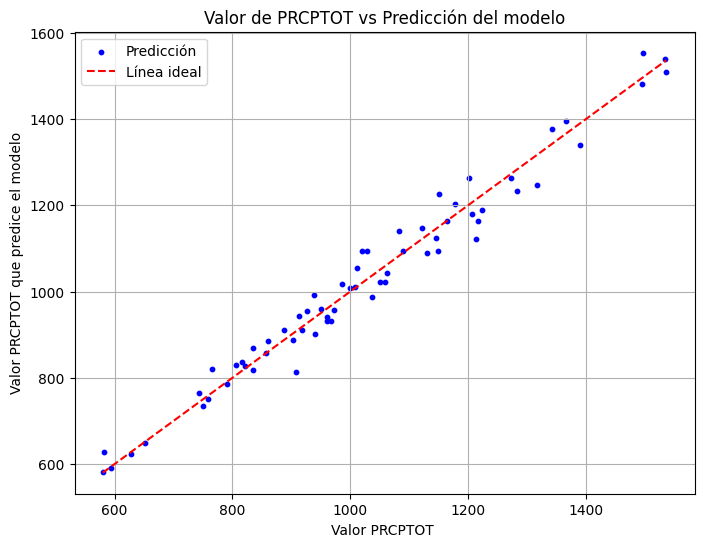

Valor de coeficiente de determinación: 0.9727260858500504
Valor del coeficiente de correlación: 0.9858153271057463

📈 Graficando mejor regresión para SDII
Variables explicativas: ['CDD', 'R20mm', 'R95pTOT', 'Rx1day']
Número de componentes principales: 3
{'component': array([[-0.05645185,  0.88012111, -0.47083071],
       [ 0.55510968, -0.27238109, -0.60025112],
       [ 0.65693534,  0.0057014 , -0.0316794 ],
       [ 0.50705265,  0.3887967 ,  0.64576579]]), 'columns': ['PC1', 'PC2', 'PC3'], 'index': Index(['CDD', 'R20mm', 'R95pTOT', 'Rx1day'], dtype='object')}
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 14.8236
B1 (PC1): 1.3132
B2 (PC2): 0.3080
B3 (PC3): -0.4576


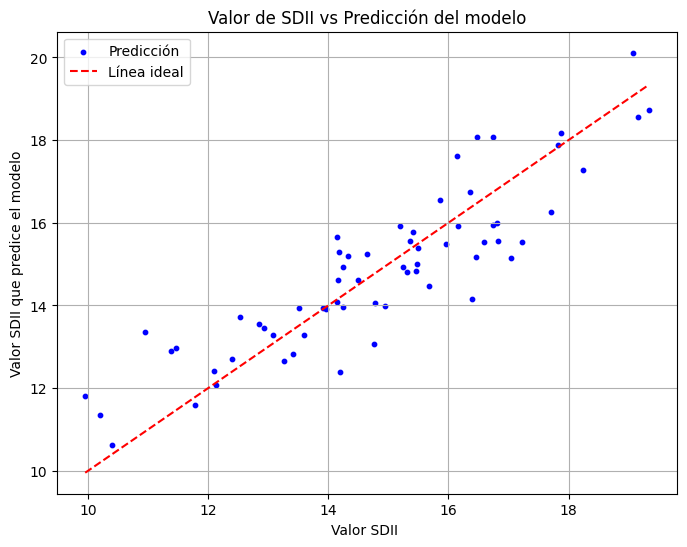

Valor de coeficiente de determinación: 0.7895340243638217
Valor del coeficiente de correlación: 0.8846657564145182

📈 Graficando mejor regresión para CWD
Variables explicativas: ['SDII', 'R20mm', 'R95pTOT', 'Rx5day']
Número de componentes principales: 3
{'component': array([[ 0.53643925, -0.18747333, -0.42186259],
       [ 0.48394986, -0.56329549,  0.65812211],
       [ 0.54023126,  0.04925801, -0.48437829],
       [ 0.43148077,  0.80319711,  0.39279119]]), 'columns': ['PC1', 'PC2', 'PC3'], 'index': Index(['SDII', 'R20mm', 'R95pTOT', 'Rx5day'], dtype='object')}
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 4.7500
B1 (PC1): 0.1646
B2 (PC2): 0.1083
B3 (PC3): 1.0927


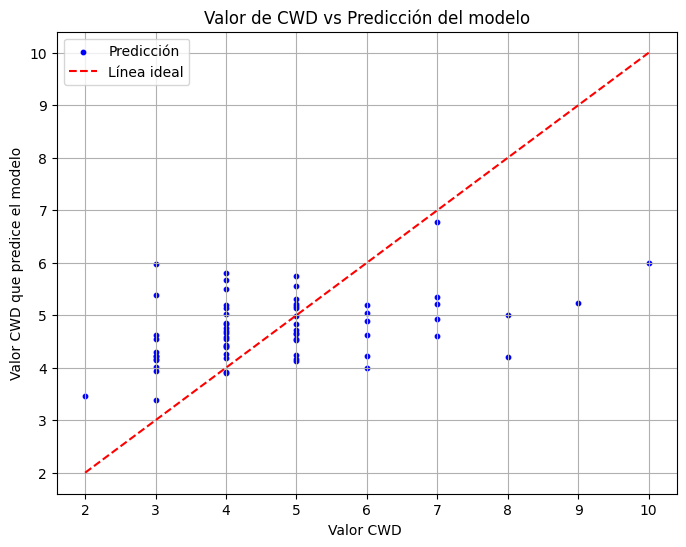

Valor de coeficiente de determinación: 0.16009720246092496
Valor del coeficiente de correlación: 0.3640870854895839

📈 Graficando mejor regresión para CDD
Variables explicativas: ['PRCPTOT', 'SDII', 'R95pTOT', 'Rx5day']
Número de componentes principales: 3
{'component': array([[ 0.50986124, -0.30947625, -0.68264008],
       [ 0.50716882, -0.31003085,  0.72912972],
       [ 0.53686427, -0.14251592, -0.04787229],
       [ 0.44113269,  0.8875779 ,  0.00897865]]), 'columns': ['PC1', 'PC2', 'PC3'], 'index': Index(['PRCPTOT', 'SDII', 'R95pTOT', 'Rx5day'], dtype='object')}
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 27.6875
B1 (PC1): 0.1821
B2 (PC2): 3.3110
B3 (PC3): 5.4347


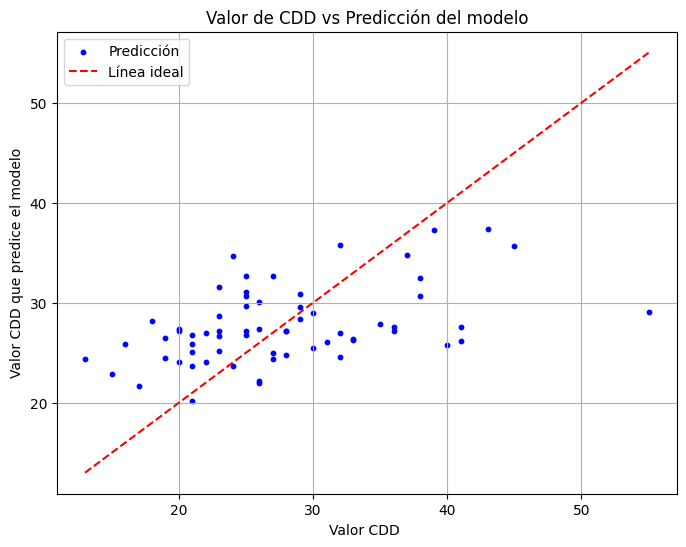

Valor de coeficiente de determinación: 0.22054351226259616
Valor del coeficiente de correlación: 0.4415739596545253

📈 Graficando mejor regresión para R10mm
Variables explicativas: ['PRCPTOT', 'CWD', 'R95pTOT']
Número de componentes principales: 3
{'component': array([[ 0.69407322, -0.11231428,  0.71108921],
       [ 0.22316401,  0.97266484, -0.06419449],
       [ 0.68444151, -0.20324519, -0.70016513]]), 'columns': ['PC1', 'PC2', 'PC3'], 'index': Index(['PRCPTOT', 'CWD', 'R95pTOT'], dtype='object')}
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 32.0312
B1 (PC1): 3.5895
B2 (PC2): -0.9763
B3 (PC3): 9.1007


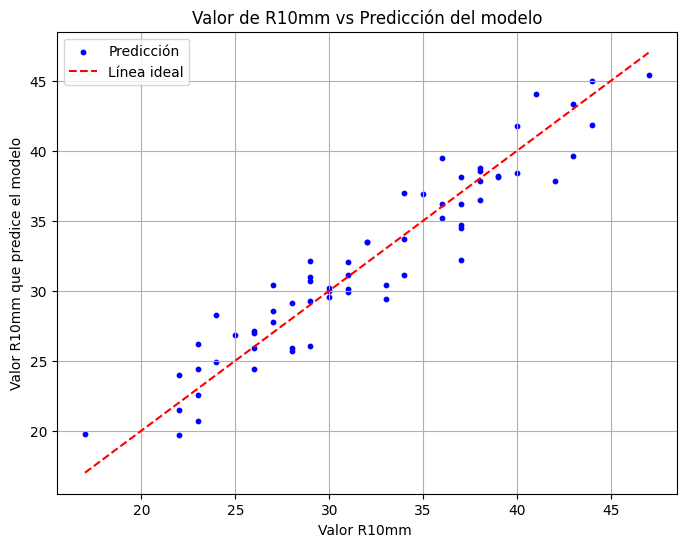

Valor de coeficiente de determinación: 0.9067565313274807
Valor del coeficiente de correlación: 0.9506310369539724

📈 Graficando mejor regresión para R20mm
Variables explicativas: ['PRCPTOT', 'SDII', 'CWD', 'Rx1day', 'Rx5day']
Número de componentes principales: 3
{'component': array([[ 0.48852682, -0.04644844, -0.64235344],
       [ 0.5184574 , -0.23874735, -0.26035117],
       [ 0.15970352,  0.95881236, -0.04848723],
       [ 0.46979391, -0.11299933,  0.6527222 ],
       [ 0.49631839,  0.09355352,  0.30199675]]), 'columns': ['PC1', 'PC2', 'PC3'], 'index': Index(['PRCPTOT', 'SDII', 'CWD', 'Rx1day', 'Rx5day'], dtype='object')}
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 16.8125
B1 (PC1): 2.0255
B2 (PC2): 0.1246
B3 (PC3): -3.7800


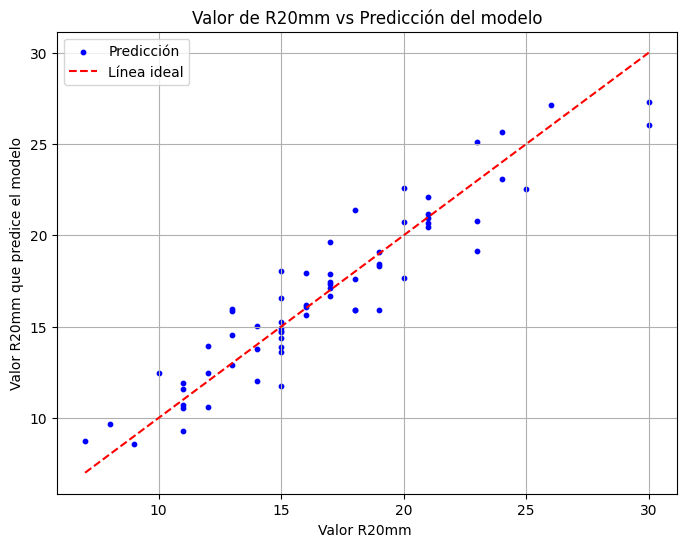

Valor de coeficiente de determinación: 0.8744328326576085
Valor del coeficiente de correlación: 0.9329072174398162

📈 Graficando mejor regresión para R40mm
Variables explicativas: ['PRCPTOT', 'CDD', 'R95pTOT', 'R99pTOT', 'Rx1day']
Número de componentes principales: 3
{'component': array([[ 4.58295370e-01, -3.48780715e-01,  5.29913883e-01],
       [-8.17571153e-05,  8.46138378e-01,  5.31458608e-01],
       [ 5.24411429e-01, -1.81760370e-01,  3.24265618e-01],
       [ 5.14301251e-01,  2.17585368e-01, -3.95441579e-01],
       [ 5.00452019e-01,  2.86394194e-01, -4.18593827e-01]]), 'columns': ['PC1', 'PC2', 'PC3'], 'index': Index(['PRCPTOT', 'CDD', 'R95pTOT', 'R99pTOT', 'Rx1day'], dtype='object')}
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 5.4219
B1 (PC1): 0.9842
B2 (PC2): -0.6066
B3 (PC3): 1.7405


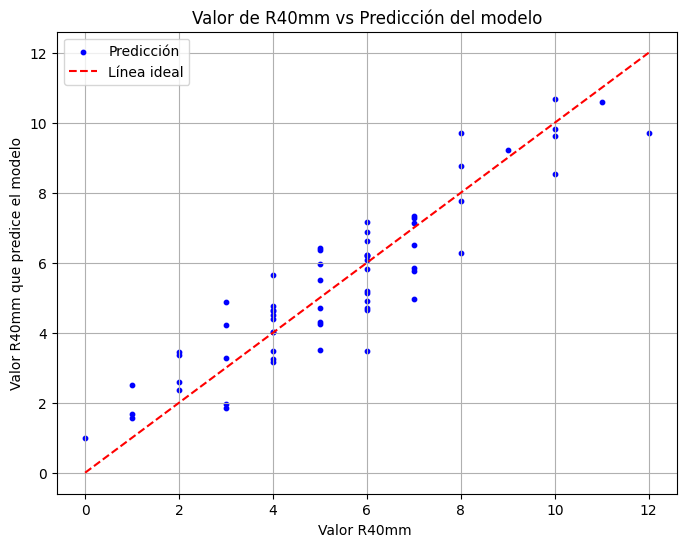

Valor de coeficiente de determinación: 0.833782851710803
Valor del coeficiente de correlación: 0.9101280729347624

📈 Graficando mejor regresión para R95pTOT
Variables explicativas: ['PRCPTOT', 'SDII', 'R10mm']
Número de componentes principales: 3
{'component': array([[ 0.62567743, -0.14735644,  0.76603775],
       [ 0.52331607,  0.80753122, -0.2720912 ],
       [ 0.57850501, -0.57112119, -0.58236805]]), 'columns': ['PC1', 'PC2', 'PC3'], 'index': Index(['PRCPTOT', 'SDII', 'R10mm'], dtype='object')}
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 245.0500
B1 (PC1): 70.8416
B2 (PC2): 60.9641
B3 (PC3): 193.6276


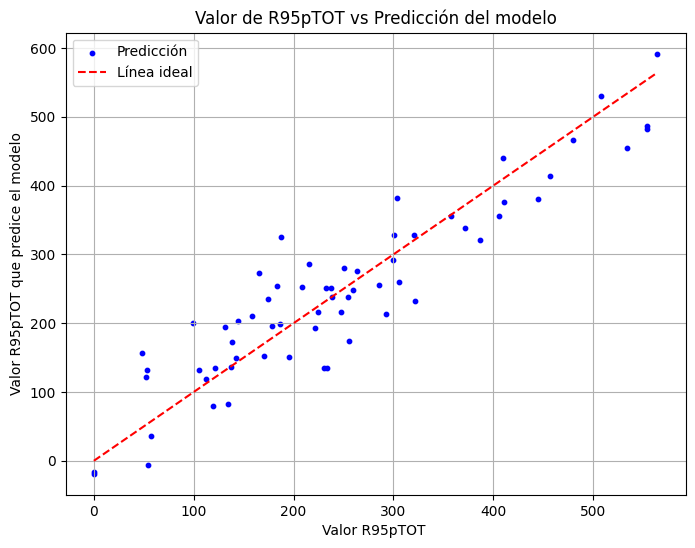

Valor de coeficiente de determinación: 0.8476937698305946
Valor del coeficiente de correlación: 0.9179869949731284

📈 Graficando mejor regresión para R99pTOT
Variables explicativas: ['PRCPTOT', 'R20mm', 'Rx1day']
Número de componentes principales: 3
{'component': array([[ 0.66555659, -0.17777705,  0.72486533],
       [ 0.63500162, -0.37546318, -0.67512988],
       [ 0.39218284,  0.90962779, -0.13700328]]), 'columns': ['PC1', 'PC2', 'PC3'], 'index': Index(['PRCPTOT', 'R20mm', 'Rx1day'], dtype='object')}
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 71.4672
B1 (PC1): 36.9672
B2 (PC2): 67.0540
B3 (PC3): 23.8825


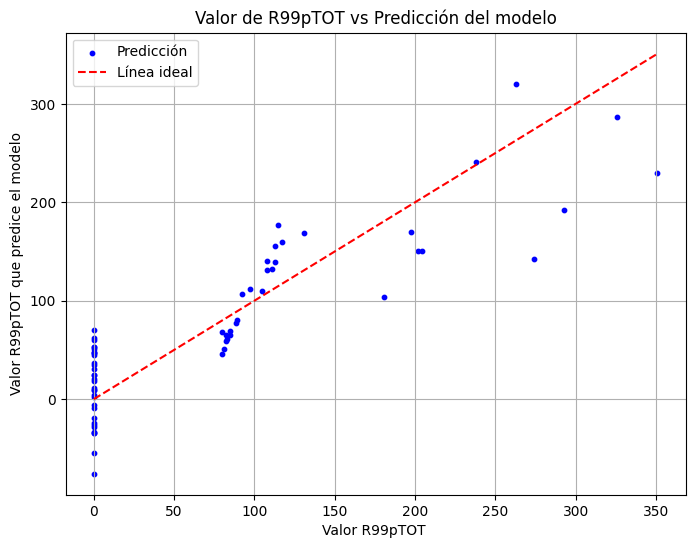

Valor de coeficiente de determinación: 0.7700874222251948
Valor del coeficiente de correlación: 0.8732406912879763

📈 Graficando mejor regresión para Rx1day
Variables explicativas: ['PRCPTOT', 'SDII', 'R20mm', 'R40mm', 'R95pTOT', 'R99pTOT', 'Rx5day']
Número de componentes principales: 3
{'component': array([[ 0.41973549, -0.24343153, -0.01470095],
       [ 0.39848655, -0.00297395, -0.30649014],
       [ 0.37582655, -0.45026559, -0.22426227],
       [ 0.39739854, -0.25686354,  0.33817894],
       [ 0.42201171,  0.07583821, -0.01221703],
       [ 0.28748224,  0.67603184, -0.50020076],
       [ 0.32422134,  0.45743174,  0.70059907]]), 'columns': ['PC1', 'PC2', 'PC3'], 'index': Index(['PRCPTOT', 'SDII', 'R20mm', 'R40mm', 'R95pTOT', 'R99pTOT', 'Rx5day'], dtype='object')}
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 84.4719
B1 (PC1): 7.6102
B2 (PC2): 18.1949
B3 (PC3): -9.6160


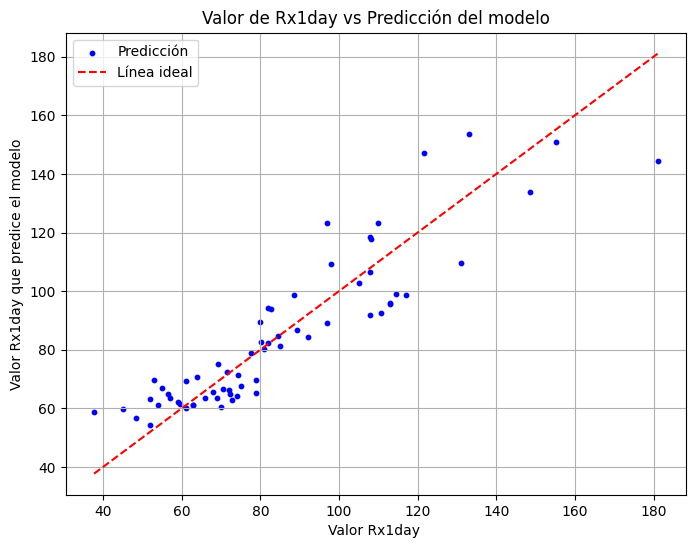

Valor de coeficiente de determinación: 0.8193639170302569
Valor del coeficiente de correlación: 0.9019098749357713

📈 Graficando mejor regresión para Rx5day
Variables explicativas: ['CWD', 'CDD', 'R40mm', 'Rx1day']
Número de componentes principales: 3
{'component': array([[ 0.34359964, -0.54195734,  0.75988359],
       [ 0.25092246,  0.82783152,  0.44536055],
       [ 0.61358803, -0.12112967, -0.45092246],
       [ 0.66519692,  0.07940286, -0.14456781]]), 'columns': ['PC1', 'PC2', 'PC3'], 'index': Index(['CWD', 'CDD', 'R40mm', 'Rx1day'], dtype='object')}
(4, 4)

Coeficientes de la regresión sobre los componentes principales:
B0 (intercepto): 129.4625
B1 (PC1): 24.0289
B2 (PC2): 1.6521
B3 (PC3): -2.3160


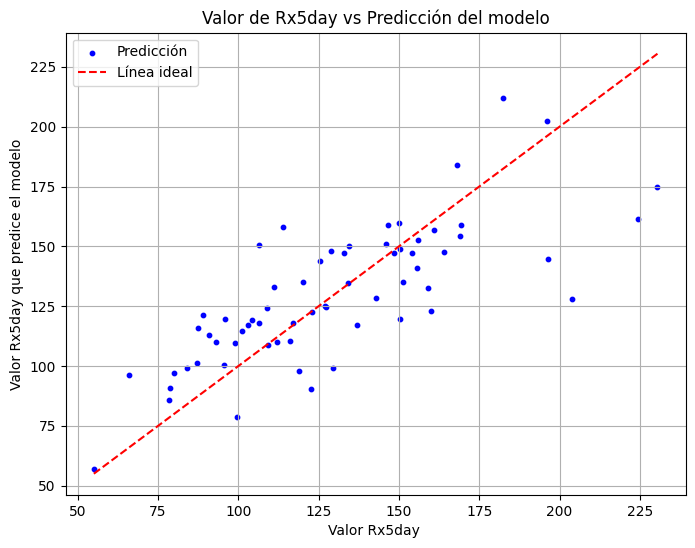

Valor de coeficiente de determinación: 0.5813273057815787
Valor del coeficiente de correlación: 0.7533925485433518


In [32]:
def graficar_mejores_regresiones(df, mejores_modelos):
    for _, fila in mejores_modelos.iterrows():
        target = fila["target"]
        mejores_vars = list(fila["mejores_vars"])
        mejor_num_comp = fila["mejor_num_comp"]

        print(f"\n📈 Graficando mejor regresión para {target}")
        print(f"Variables explicativas: {mejores_vars}")
        print(f"Número de componentes principales: {mejor_num_comp}")

        # Calcular PCA con las variables óptimas
        X_pca, _ = calcular_PCA(df, mejores_vars, mejor_num_comp)

        print(_)
        # Calcular regresión lineal múltiple
        y, y_pred = calcular_regresion_multiple(df, target, X_pca)

        # Mostrar gráfico
        graficar_regresion_multiple(y, y_pred, target)

        # Mostrar métricas de rendimiento
        obtener_metricas_regresion(y, y_pred)

graficar_mejores_regresiones(df_indices_anual, mejores_modelos)
